Profit function (Paquette Loss):  
$$\Pi:= \sum_{\textit{weeks with output } 1} 1\cdot(Close-Open)+\sum_{\textit{weeks with output } -1} -1\cdot(Close-Open)= \sum_{\textit{all weeks}} Output_{week}\cdot(Close-Open)$$

In [1]:
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import sys
sys.path.append(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\anfis_libraries')
#sys.path.append(r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\anfis')

import anfis
import membership 
import experimental
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
#msft = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\Microsoft_weekly_ok.csv')
amzn = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\Amazon_weekly_ok.csv')
#amzn = pd.read_csv(r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\Weekly series\Amazon_weekly_ok.csv', index_col=False, parse_dates=['Date'])
#ibm = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\IBM_weekly_ok.csv')
#cac = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\Cac_weekly_ok.csv')
#sp500 = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\Sp500_weekly_ok.csv')
#nasdaq = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\Nasdaq_weekly_ok.csv')

In [3]:
# Function to add indicators
def calculate_indicators(df, rsi_period=14, cci_period=20, ma_short_period=10, ma_long_period=40):

    # Moving Averages with dynamic column names based on periods
    ma_short_column = f'MA{ma_short_period}'
    ma_long_column = f'MA{ma_long_period}'
    normalized_difference_column = f'MA{ma_long_period}_MA{ma_short_period}_difference_normalized'

    # Calculate short and long period moving averages
    df[ma_short_column] = df['Close'].rolling(window=ma_short_period).mean()
    df[ma_long_column] = df['Close'].rolling(window=ma_long_period).mean()

    # Calculate the normalized difference of moving averages
    df[normalized_difference_column] = (df[ma_short_column] - df[ma_long_column]) / df[ma_long_column]

    # Calculate RSI (Relative Strength Index)
    price_change = df['Close'].diff()
    upward_changes = price_change.clip(lower=0)
    downward_changes = -price_change.clip(upper=0)
    average_upward_changes = upward_changes.rolling(window=rsi_period).mean()
    average_downward_changes = downward_changes.rolling(window=rsi_period).mean()
    relative_strength = average_upward_changes / average_downward_changes
    df['RSI'] = 100 - (100 / (1 + relative_strength))

    # Calculate CCI (Commodity Channel Index)
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    sma_typical_price = typical_price.rolling(window=cci_period).mean()
    mean_deviation = (typical_price - sma_typical_price).abs().rolling(window=cci_period).mean()
    df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)

    # Calculate CPC (Current Price Change)
    rolling_mean_close = df['Close'].rolling(window=4).mean()
    df['CPC'] = 1 / (1 + np.exp(-(df['Close'] - rolling_mean_close.shift(1)) / rolling_mean_close.shift(1) * 100))
    
    df.drop(columns=[ma_short_column, ma_long_column], inplace=True)
    
    return df

In [4]:
# List of DataFrames
#dfs = [amzn, cac, ibm, msft, nasdaq, sp500]
dfs=[amzn]

for df in dfs:
    # Verify dates are datetime
    df['Date'] = pd.to_datetime(df['Date'])
    # Verify dates are sorted
    df.sort_values('Date', inplace=True)
    
    calculate_indicators(df)

In [5]:
amzn.head(41)

,Date,Open,High,Low,Close,MA40_MA10_difference_normalized,RSI,CCI,CPC
0,1997-05-18,0.075000,0.125000,0.075000,0.086460,NaN,NaN,NaN,NaN
1,1997-05-25,0.088021,0.088542,0.065625,0.075000,NaN,NaN,NaN,NaN
2,1997-06-01,0.075521,0.082292,0.072917,0.075000,NaN,NaN,NaN,NaN
3,1997-06-08,0.075521,0.085417,0.068750,0.082815,NaN,NaN,NaN,NaN
4,1997-06-15,0.082812,0.085417,0.076562,0.079170,NaN,NaN,NaN,0.307299
5,1997-06-22,0.080208,0.080208,0.074740,0.076305,NaN,NaN,NaN,0.102627
6,1997-06-29,0.077083,0.077083,0.073958,0.074480,NaN,NaN,NaN,0.007348
7,1997-07-06,0.075521,0.095833,0.073958,0.095575,NaN,NaN,NaN,1.000000
8,1997-07-13,0.091667,0.128646,0.091667,0.114585,NaN,NaN,NaN,1.000000
9,1997-07-20,0.116146,0.124740,0.105729,0.107815,NaN,NaN,NaN,1.000000


In [6]:
# Drop rows with na, depending on parameters chosen for indicators
amzn.drop(index=amzn.index[0:39], inplace=True)
amzn.reset_index(inplace=True)

In [7]:
amzn.columns

Index(['index', 'Date', 'Open', 'High', 'Low', 'Close',
       'MA40_MA10_difference_normalized', 'RSI', 'CCI', 'CPC'],
      dtype='object')

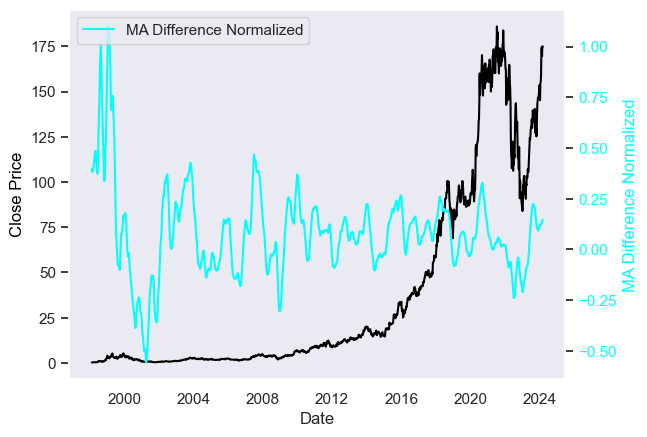

In [8]:
sns.set(style="dark")

fig, ax = plt.subplots()
ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')
#ax.tick_params(axis='y', labelcolor='white')
#ax.legend()

ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['MA40_MA10_difference_normalized'], color='cyan', label='MA Difference Normalized')
ax2.set_ylabel('MA Difference Normalized', color='cyan')
ax2.tick_params(axis='y', labelcolor='cyan')
ax2.legend(loc='upper left')

plt.show()

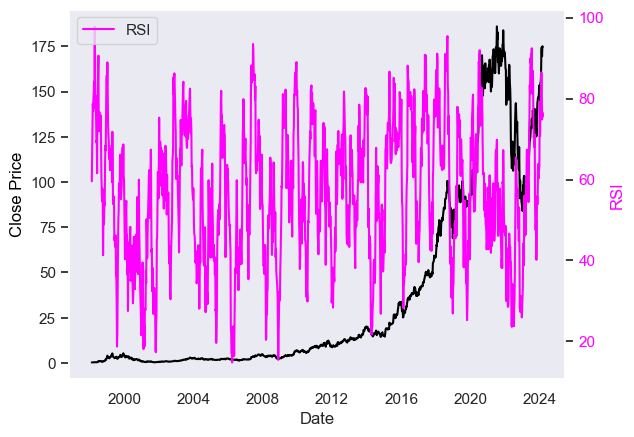

In [9]:
fig, ax = plt.subplots()
ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')
#ax.tick_params(axis='y', labelcolor='white')
#ax.legend()

ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['RSI'], color='magenta', label='RSI')
ax2.set_ylabel('RSI', color='magenta')
ax2.tick_params(axis='y', labelcolor='magenta')
ax2.legend(loc='upper left')

plt.show()

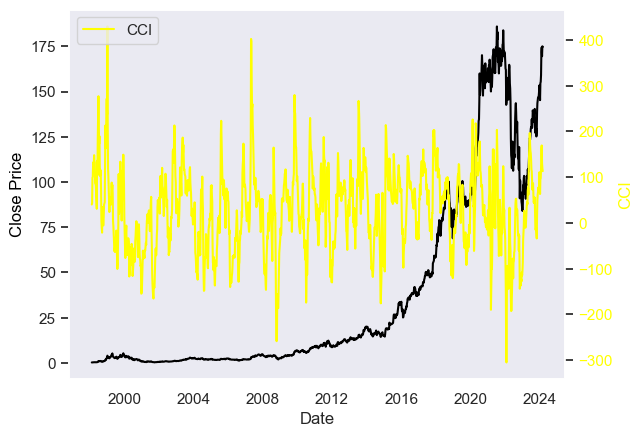

In [10]:
fig, ax = plt.subplots()
ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')
#ax.tick_params(axis='y', labelcolor='white')
#ax.legend()

ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['CCI'], color='yellow', label='CCI')
ax2.set_ylabel('CCI', color='yellow')
ax2.tick_params(axis='y', labelcolor='yellow')
ax2.legend(loc='upper left')

plt.show()

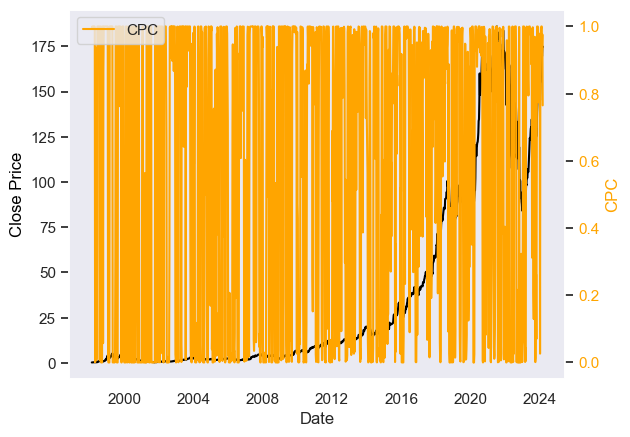

In [11]:
fig, ax = plt.subplots()
ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')
#ax.tick_params(axis='y', labelcolor='white')
#ax.legend()

ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['CPC'], color='orange', label='CPC')
ax2.set_ylabel('CPC', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper left')

plt.show()

Target variable is Market Behavior:
- Bullish (upcoming week’s close is higher than the current week’s close): Assign +1.  
- Bearish (upcoming week’s close is lower than the current week’s close): Assign -1.  
- Flat (upcoming week’s close is approximately, according to a threshold, equal to the current week’s close): Assign 0.

In [12]:
# Calculate the percentage change in closing price from one week to the next
amzn.loc[:, 'Next_week_pct_change'] = 100*(amzn['Close'].pct_change(periods=1).shift(-1))

# Define a threshold for what we consider to be a flat week, e.g. 1% price change
# Define a function to categorize the change as +1, 0, or -1
def categorize_change(weekly_return, flat_threshold=1):
    if weekly_return > flat_threshold:
        return 1  # Bullish
    elif weekly_return < -flat_threshold:
        return -1  # Bearish
    else:
        return 0  # Flat

# Apply the function to the percentage change column to create the target variable
amzn.loc[:, 'Next_week_market_behavior'] = amzn['Next_week_pct_change'].apply(categorize_change)
amzn.loc[:, 'Log_return'] = np.log(amzn['Close'].shift(-1) / amzn['Close'])

# Drop the last row as it contains NaN in the 'Next_week_pct_change' column
amzn = amzn[1:-1]

In [13]:
amzn

,index,Date,Open,High,Low,Close,MA40_MA10_difference_normalized,RSI,CCI,CPC,Next_week_pct_change,Next_week_market_behavior,Log_return
1,40,1998-02-22,0.260937,0.264583,0.252604,0.263545,0.381240,65.867678,43.527506,0.996641,21.738223,1,0.196703
2,41,1998-03-01,0.264583,0.331771,0.260417,0.320835,0.387294,72.396160,98.693459,1.000000,-0.324154,0,-0.003247
3,42,1998-03-08,0.316146,0.328125,0.291667,0.319795,0.392028,78.683845,100.946250,1.000000,2.523492,1,0.024922
4,43,1998-03-15,0.320312,0.367708,0.319792,0.327865,0.389265,76.889157,128.911091,0.999997,6.751254,1,0.065331
5,44,1998-03-22,0.331510,0.364583,0.324479,0.350000,0.410742,80.411708,132.953136,0.999999,1.191429,1,0.011844
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354,1393,2024-01-28,156.890000,160.720000,153.900000,159.120000,0.122564,83.740807,117.881785,0.992096,7.975113,1,0.076731
1355,1394,2024-02-04,159.340000,172.500000,154.810000,171.810000,0.127295,86.463677,162.285928,0.999993,1.536581,1,0.015249
1356,1395,2024-02-11,170.200000,175.000000,167.650000,174.450000,0.133117,84.332503,169.431959,0.999861,-2.831757,-1,-0.028726
1357,1396,2024-02-18,174.800000,175.390000,165.750000,169.510000,0.136922,74.861084,130.653961,0.932225,3.232848,1,0.031817


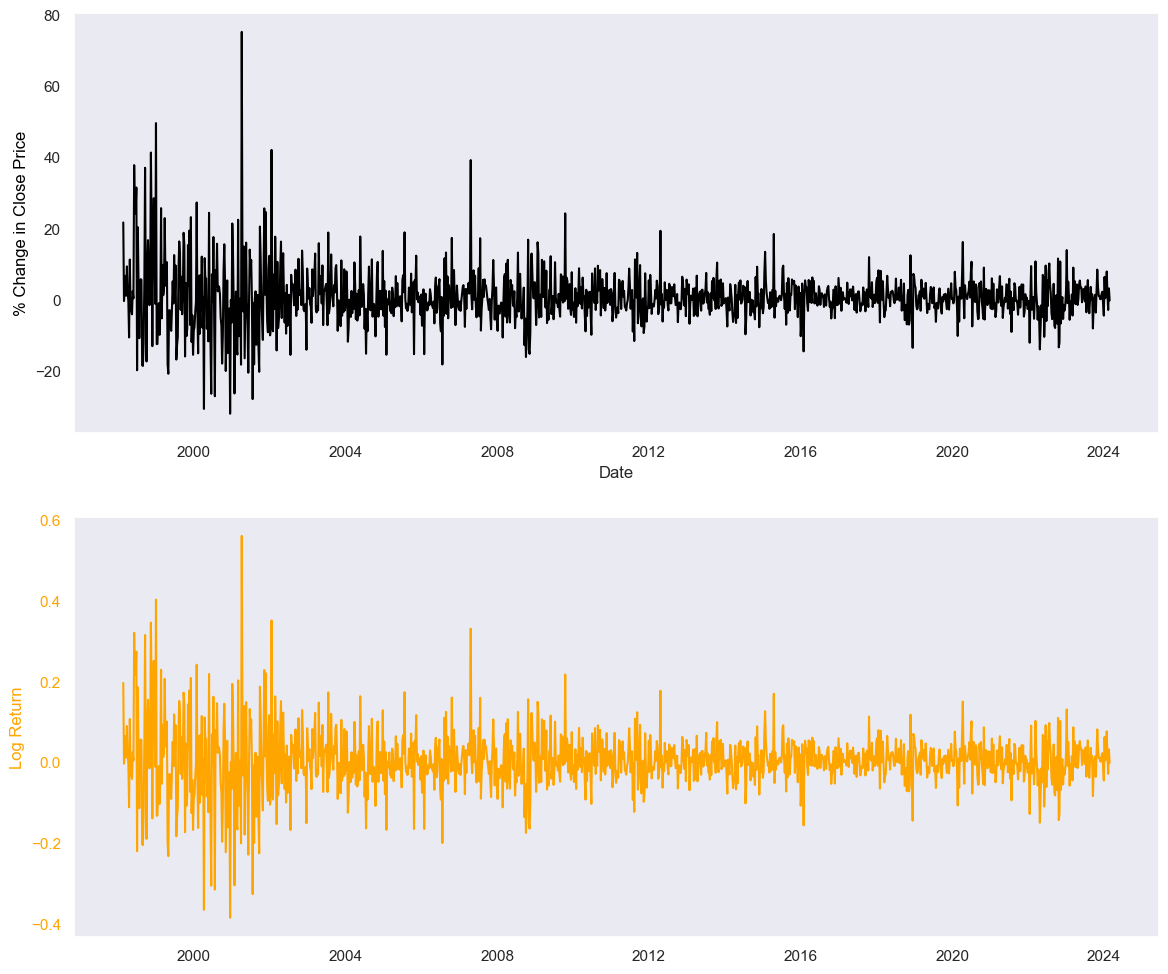

In [14]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 12))
axes[0].plot(amzn['Date'], amzn['Next_week_pct_change'], color='Black', label='% change')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('% Change in Close Price', color='Black')
#ax.tick_params(axis='y', labelcolor='white')
#ax.legend()

axes[1].plot(amzn['Date'], amzn['Log_return'], color='orange', label='Log Return')
axes[1].set_ylabel('Log Return', color='orange')
axes[1].tick_params(axis='y', labelcolor='orange')

In [15]:
# Define your feature columns
feature_columns = ['MA40_MA10_difference_normalized', 'RSI', 'CCI', 'CPC']

# Now let's prepare the features
features = amzn[feature_columns]

# Prepare the target
target = amzn['Next_week_market_behavior']+1

# Calculate the index for the split
split_idx = int(len(features) * 0.8)

# Split the features and target into training/testing sets without shuffling
X_train = features.iloc[:split_idx]
X_test = features.iloc[split_idx:]
y_train = target.iloc[:split_idx]
y_test = target.iloc[split_idx:]

# Convert to PyTorch tensors
train_data = TensorDataset(torch.FloatTensor(X_train.values), torch.LongTensor(y_train.values))
test_data = TensorDataset(torch.FloatTensor(X_test.values), torch.LongTensor(y_test.values))

# Create Data Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)  # Usually, you don't shuffle time series data
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [16]:
# Define the membership functions for RSI and store in invars:
invars = [
    ('RSI', [
        membership.GaussMembFunc(50, 10),
        membership.SigmoidMembFunc(-0.1, 30),  # less steep slope
        membership.SigmoidMembFunc(0.1, 70)
    ]),
    ('CCI', [
        membership.GaussMembFunc(0, 70),
        membership.SigmoidMembFunc(-0.1, -100),  # less steep slope
        membership.SigmoidMembFunc(0.1, 100)
    ]),
    ('CPC', [
        membership.GaussMembFunc(0.5, 0.35),
        membership.SigmoidMembFunc(-0.1, -0.2),  # less steep slope
        membership.SigmoidMembFunc(0.1, 0.8)
    ]),
    ('MADN', [
        membership.GaussMembFunc(0, 0.2),
        membership.SigmoidMembFunc(-0.1, -0.25),  # less steep slope
        membership.SigmoidMembFunc(0.1, 0.25)
    ])
]

model = anfis.AnfisNetClassifier(invardefs=invars, num_classes=3)

#coeff_shape = torch.Size([model.num_rules, model.num_classes, model.num_in+1])

# Initialize the consequent parameters and set them to small (10^-2) random values using the coeff property setter
#model.coeff = torch.randn(coeff_shape, dtype=torch.float) * 0.1

In [17]:
model.coeff

Parameter containing:
tensor([[[-1.8516e-02,  6.4060e-02,  1.8476e-01,  3.6815e-02, -4.1119e-02],
         [-6.4599e-02,  1.4226e-01,  3.8266e-02,  4.2292e-02, -1.1621e-01],
         [ 8.1515e-02, -2.0671e-02,  1.0682e-01,  2.0695e-01,  3.4643e-02]],

        [[ 2.5287e-01, -1.4148e-01, -4.1119e-02, -1.6120e-01, -1.6095e-01],
         [-3.8558e-02,  1.4032e-01, -4.4583e-03,  5.3113e-02,  3.0787e-01],
         [ 1.1133e-01, -6.1731e-03,  5.3856e-04, -1.9840e-01,  7.4783e-02]],

        [[ 3.3619e-02, -5.9462e-02, -1.2489e-02, -4.0202e-02, -9.3993e-03],
         [-5.5956e-02,  1.0863e-01, -2.0598e-02,  1.1380e-01,  1.3753e-01],
         [ 1.3400e-01, -1.1024e-01,  1.7963e-01, -1.2446e-04,  5.4717e-02]],

        ...,

        [[ 5.0484e-02,  1.8850e-01,  1.4053e-01, -7.9792e-03, -2.3700e-02],
         [ 1.4339e-01,  2.7381e-02, -4.0672e-02,  5.1784e-02, -4.6001e-02],
         [-1.2975e-01, -2.8536e-02, -1.2947e-01,  6.7648e-02,  2.0633e-03]],

        [[ 8.5469e-02, -3.6174e-02, -1.8468e

### Training for 200 epochs, training size = 1086 cases
epoch    0: Loss=3.71689
epoch   10: Loss=2.81947
epoch   20: Loss=2.12762
epoch   30: Loss=1.28813
epoch   40: Loss=1.10313
epoch   50: Loss=1.05314
epoch   60: Loss=1.03765
epoch   70: Loss=1.03020
epoch   80: Loss=1.02610
epoch   90: Loss=1.02348
epoch  100: Loss=1.02160
epoch  110: Loss=1.02015
epoch  120: Loss=1.01898
epoch  130: Loss=1.01801
epoch  140: Loss=1.01720
epoch  150: Loss=1.01649
epoch  160: Loss=1.01588
epoch  170: Loss=1.01534
epoch  180: Loss=1.01485
epoch  190: Loss=1.01440
epoch  199: Loss=1.01404


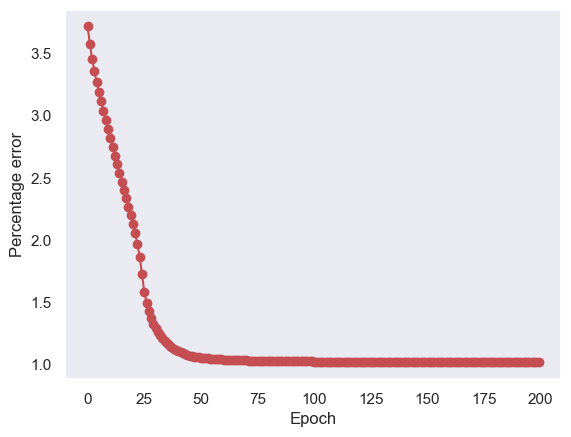

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
experimental.train_anfis_classifier_with(model=model, data=train_loader, optimizer=optimizer, epochs=200, show_plots=True)

In [23]:
X_train_data = torch.FloatTensor(X_train.values)  # Convert features to a tensor
predict_loader = DataLoader(X_train_data, batch_size=64, shuffle=False)

predictions=experimental.classification_predictions(model, predict_loader)

In [ ]:
'''
# Accuracy
accuracy = accuracy_score(actual_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# Confusion Matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels)
print('Confusion Matrix:\n', conf_matrix)

# Classification Report
class_report = classification_report(actual_labels, predicted_labels)
print('Classification Report:\n', class_report)
'''

In [ ]:
'''
David: use ANFIS as in example 4 of the paper
features=pd.DataFrame()

features['xtp6']=amzn['Next_week_pct_change'].shift(-6)
features['xt']=amzn['Next_week_pct_change']
features['xtm6']=amzn['Next_week_pct_change'].shift(6)
features['xtm12']=amzn['Next_week_pct_change'].shift(12)
features['xtm18']=amzn['Next_week_pct_change'].shift(18)
features
''' 